# Plotting our co-ordinates in the original data

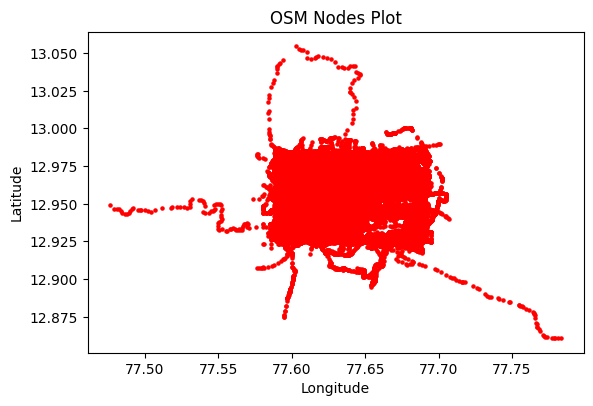

In [57]:
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

file_path = 'map'

tree = ET.parse(file_path)
root = tree.getroot()

nodes = []
for node in root.findall('node'):
    lat = float(node.get('lat'))
    lon = float(node.get('lon'))
    nodes.append((lon, lat))

gdf = gpd.GeoDataFrame(
    {'geometry': [Point(lon, lat) for lon, lat in nodes]},
    crs="EPSG:4326"
)
gdf.plot(marker='o', color='red', markersize=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('OSM Nodes Plot')
plt.show()


# Group data from OSM by user, and then sort for each user by the timestamp

In [59]:
import xml.etree.ElementTree as ET
import pandas as pd

data = []

for node in root.findall('node'):
    user = node.get('user')
    if user:
        node_data = {
            'id': node.get('id'),
            'user': user,
            'uid': node.get('uid'),
            'lat': node.get('lat'),
            'lon': node.get('lon'),
            'timestamp': node.get('timestamp'),
            'changeset': node.get('changeset')
        }
        data.append(node_data)

df = pd.DataFrame(data)

df_sorted = df.sort_values(by=['user', 'timestamp'])
df_sorted.to_csv('eta_prediction_data.csv', index=False)

print("Data has been processed and saved successfully.")


Data has been processed and saved successfully.


# use two consecutive entries for a user, to get the segment of a road(initial longitude/latitude, final longitude/latitude) and the time for that segment(by subtracting timestamp).<br> 
# But make sure distance is between 200 meter to 1 km  

In [64]:

import pandas as pd
import math

# Function to compute distance between two lat/lon points using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c * 1000  
    return distance

data = []

for node in root.findall('node'):
    user = node.get('user')
    if user:
        node_data = {
            'id': node.get('id'),
            'user': user,
            'uid': node.get('uid'),
            'lat': float(node.get('lat')),
            'lon': float(node.get('lon')),
            'timestamp': node.get('timestamp'),
            'changeset': node.get('changeset')
        }
        data.append(node_data)

df = pd.DataFrame(data)

df_sorted = df.sort_values(by=['user', 'timestamp'])

df_sorted['timestamp'] = pd.to_datetime(df_sorted['timestamp'])

result_data = []

for user, group in df_sorted.groupby('user'):
    group = group.reset_index(drop=True)
    for i in range(1, len(group)):
        initial_lat = group.at[i-1, 'lat']
        initial_lon = group.at[i-1, 'lon']
        final_lat = group.at[i, 'lat']
        final_lon = group.at[i, 'lon']
        time_taken = (group.at[i, 'timestamp'] - group.at[i-1, 'timestamp']).total_seconds()
        
        distance = haversine(initial_lat, initial_lon, final_lat, final_lon)
        
        if 200 <= distance <= 1000: 
            result_data.append({
                'user': user,
                'initial_lat': initial_lat,
                'initial_lon': initial_lon,
                'final_lat': final_lat,
                'final_lon': final_lon,
                'time_taken': time_taken,
            })

df_result = pd.DataFrame(result_data)





In [65]:
df_result.describe()

,initial_lat,initial_lon,final_lat,final_lon,time_taken
count,46479.000000,46479.000000,46479.000000,46479.000000,4.647900e+04
mean,12.954251,77.628208,12.954229,77.628218,5.622524e+04
std,0.018305,0.028370,0.018279,0.028382,1.706276e+06
min,12.860758,77.482024,12.860915,77.483497,0.000000e+00
25%,12.938835,77.604927,12.938826,77.604947,0.000000e+00
50%,12.953632,77.623081,12.953643,77.623111,0.000000e+00
75%,12.970875,77.646914,12.970808,77.646917,0.000000e+00
max,13.054299,77.781263,13.052863,77.783441,1.473936e+08


# histogram shows that too many entries in "time_taken" feature are too large, like 42000 sec, which means that those entries are when people were at two different ocassions and not while travelling during the same journey. Similarly some entries have it as too small.

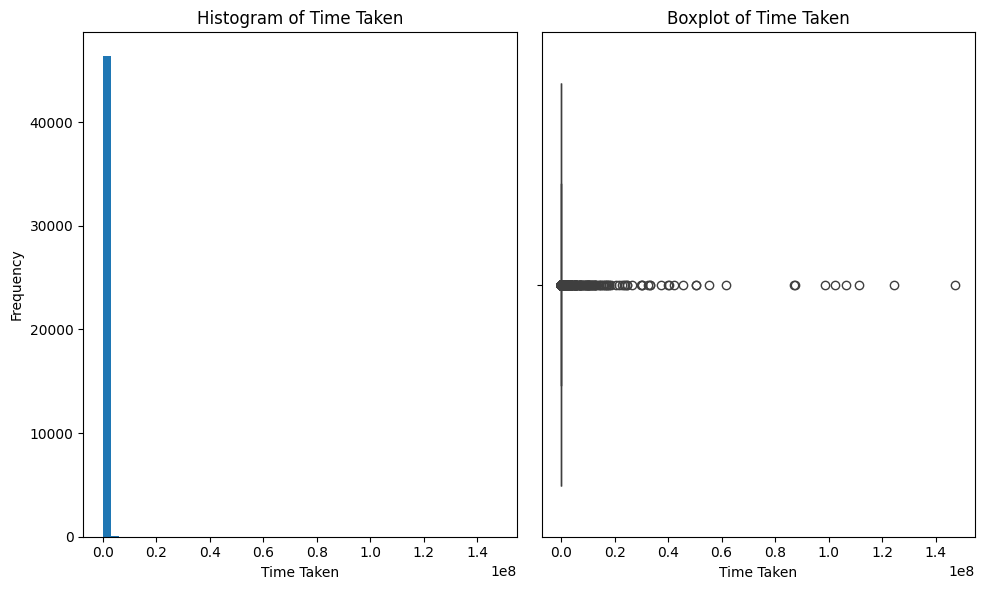

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df_result['time_taken'], bins=50)
plt.title('Histogram of Time Taken')
plt.xlabel('Time Taken')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_result['time_taken'])
plt.title('Boxplot of Time Taken')
plt.xlabel('Time Taken')

plt.tight_layout()
plt.show()

# plots for new data after cleaning. 
# This is relevant data as the segments left in this dataset are not too large and not too small.

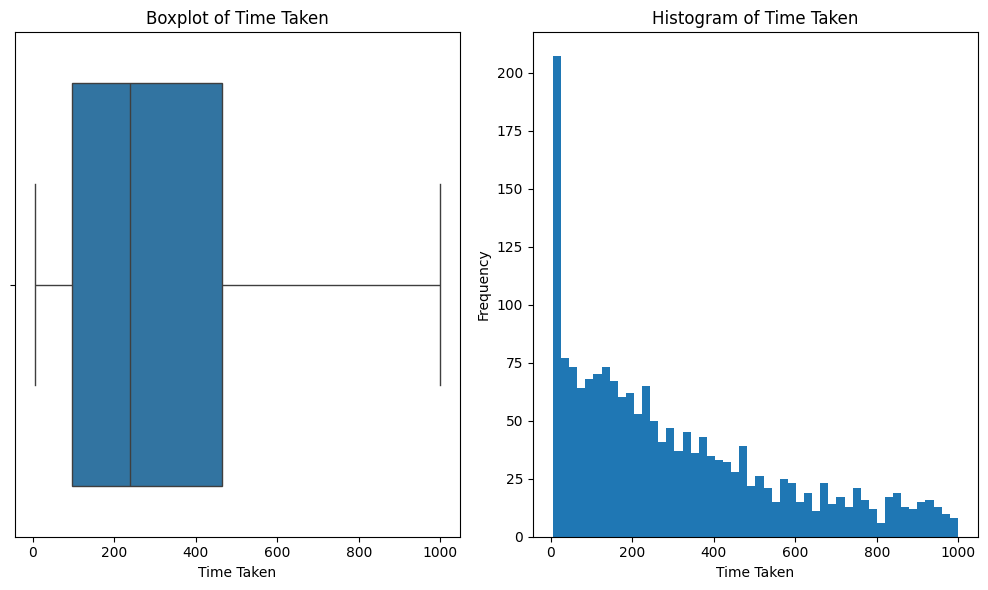

In [70]:
df_result = df_result[df_result['time_taken'] >5]
df_result = df_result[df_result['time_taken'] <1000]
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_result['time_taken'])
plt.title('Boxplot of Time Taken')
plt.xlabel('Time Taken')

plt.subplot(1, 2, 2)
plt.hist(df_result['time_taken'], bins=50)
plt.title('Histogram of Time Taken')
plt.xlabel('Time Taken')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

removing outliers, just to be sure.

In [71]:
df_result.describe()

,initial_lat,initial_lon,final_lat,final_lon,time_taken
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,12.959979,77.631284,12.959720,77.631523,308.312534
std,0.016746,0.027473,0.016679,0.027485,261.379803
min,12.918904,77.585732,12.916439,77.585732,6.000000
25%,12.946583,77.608652,12.946484,77.608165,96.000000
50%,12.963364,77.627746,12.963244,77.628173,238.000000
75%,12.973962,77.647685,12.973738,77.648689,465.000000
max,12.987484,77.693605,12.989962,77.692848,999.000000


In [72]:
df_result.to_csv('eta_prediction_data.csv', index=False)

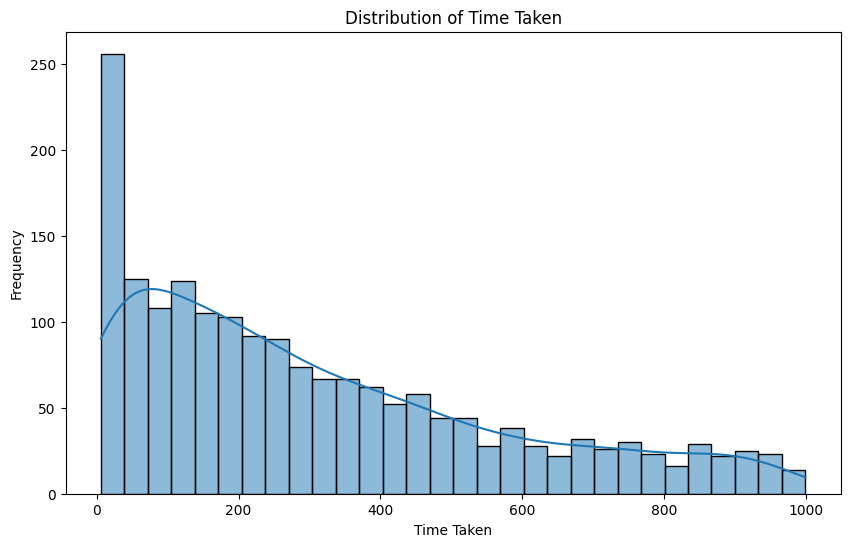

In [73]:

# Histogram of the 'time_taken' feature
plt.figure(figsize=(10, 6))
sns.histplot(df_result['time_taken'], bins=30, kde=True)  # kde=True adds a Kernel Density Estimate curve
plt.title('Distribution of Time Taken')
plt.xlabel('Time Taken')
plt.ylabel('Frequency')
plt.show()




# Normalize co-ordinates as the inital few numbers are same for most points in the dataset.
# To make sure that the route we generate are real roads, we use the OSM api and chose driving roads.
# Also split up the route into sub-segments if the segment is longer than 1km.
# For those individual segments we predict the ETA
# But still, the length of the original segment and interpolated segment might be different. We need to fix this.
# The final ETA is the summation of the individual ETA of the segments.

Estimated Time of Arrival (ETA) between the two locations: 6.40 minutes


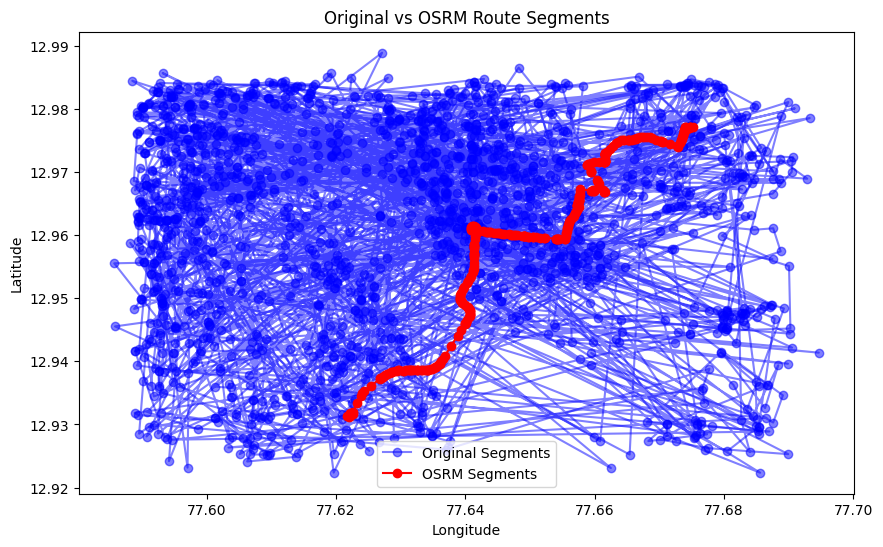

In [74]:
import requests
import pandas as pd
from geopy.distance import great_circle
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

osrm_url = "http://router.project-osrm.org/route/v1/driving/{},{};{},{}?overview=full&geometries=geojson"

start_location = (12.9317652, 77.6209215) 
end_location = (12.9771376, 77.6751392) 

route_url = osrm_url.format(start_location[1], start_location[0], end_location[1], end_location[0])
response = requests.get(route_url)
route_data = response.json()

coordinates = route_data['routes'][0]['geometry']['coordinates']
segment_points = [(coord[1], coord[0]) for coord in coordinates]

df = pd.read_csv('cleaned_eta_prediction_data.csv')

def calculate_segment_length(start, end):
    return great_circle(start, end).meters

def divide_segment(segment_start, segment_end, max_length=1000):
    segments = []
    total_distance = calculate_segment_length(segment_start, segment_end)
    
    if total_distance <= max_length:
        segments.append((segment_start, segment_end))
    else:
        num_subsegments = int(total_distance // max_length) + 1
        lat_diff = (segment_end[0] - segment_start[0]) / num_subsegments
        lon_diff = (segment_end[1] - segment_start[1]) / num_subsegments
        
        for i in range(num_subsegments):
            sub_start = (segment_start[0] + i * lat_diff, segment_start[1] + i * lon_diff)
            sub_end = (segment_start[0] + (i + 1) * lat_diff, segment_start[1] + (i + 1) * lon_diff)
            segments.append((sub_start, sub_end))
    
    return segments

df['segment_length'] = df.apply(lambda row: calculate_segment_length((row['initial_lat'], row['initial_lon']), 
                                                                     (row['final_lat'], row['final_lon'])), axis=1)

X = df[['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length']]
y = df['time_taken']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_normalized, y)

total_eta = 0

for i in range(len(segment_points) - 1):
    segment_start = segment_points[i]
    segment_end = segment_points[i + 1]
    
    segments = divide_segment(segment_start, segment_end, max_length=1000)
    
    for sub_start, sub_end in segments:
        segment_length = calculate_segment_length(sub_start, sub_end)

        segment_df = pd.DataFrame([[sub_start[0], sub_start[1], sub_end[0], sub_end[1], segment_length]],
                                  columns=['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length'])
        
        segment_normalized = scaler.transform(segment_df)

        predicted_eta = knn.predict(segment_normalized)[0]

        adjusted_eta = predicted_eta * (segment_length / average_segment_length)
        total_eta += adjusted_eta

print(f"Estimated Time of Arrival (ETA) between the two locations: {total_eta / 60:.2f} minutes")


plt.figure(figsize=(10, 6))

plt.plot(df['initial_lon'], df['initial_lat'], 'bo-', alpha=0.5, label='Original Segments')
plt.plot(df['final_lon'], df['final_lat'], 'bo-', alpha=0.5)

lats, lons = zip(*segment_points)
plt.plot(lons, lats, 'ro-', label='OSRM Segments')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original vs OSRM Route Segments')
plt.legend()
plt.show()


# For real time updates, I simply added a loop.<br>
# To get real time user location, ipstack API was used.<br>
# The api key is hard coded for testing purposes for the assignment.


Current Location: (28.621299743652344, 77.21029663085938)
Updated ETA from current location ((28.621299743652344, 77.21029663085938)) to destination: 820.14 minutes


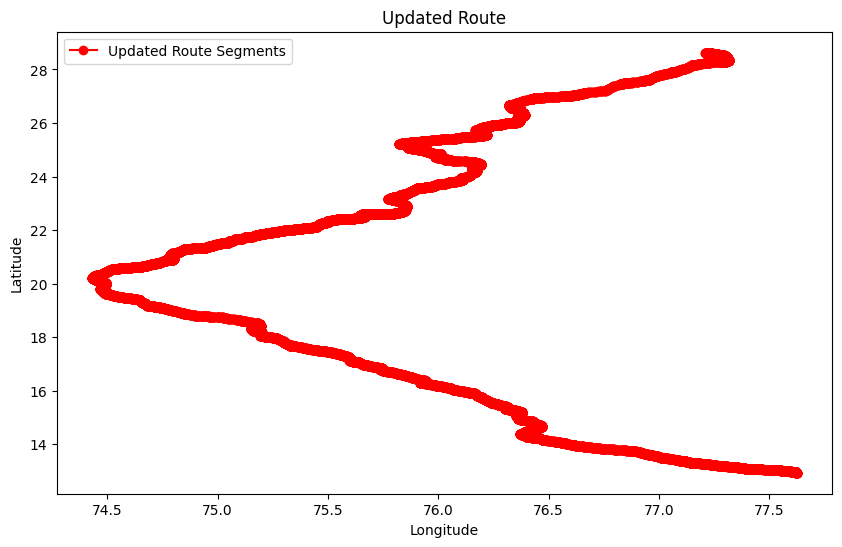

Updated ETA from current location ((28.621299743652344, 77.21029663085938)) to destination: 820.14 minutes


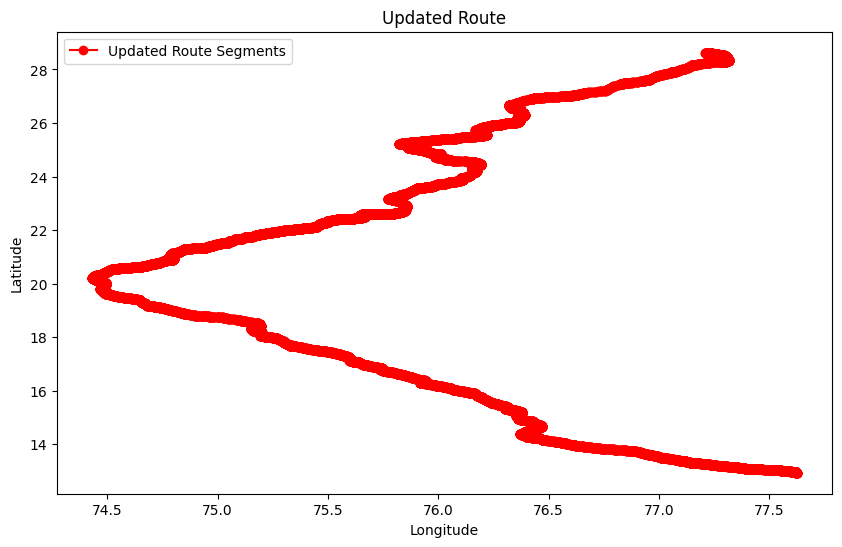

Updated ETA from current location ((28.621299743652344, 77.21029663085938)) to destination: 820.14 minutes


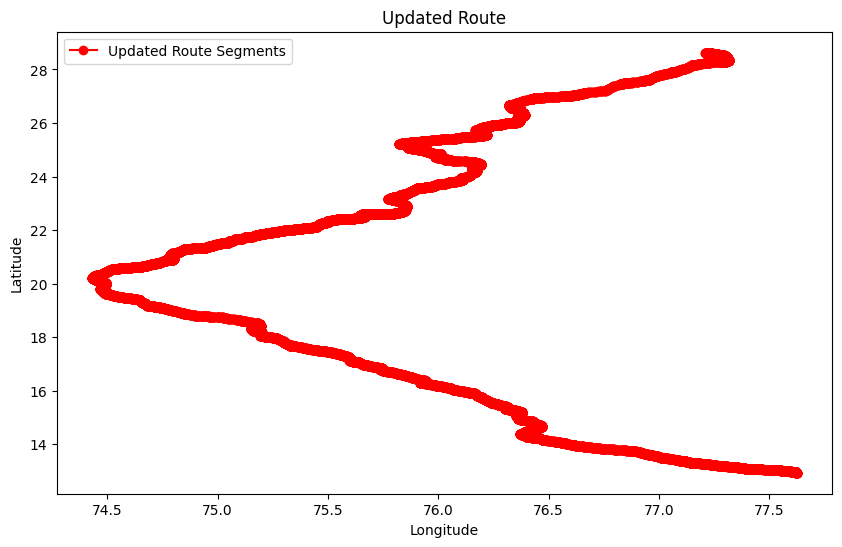

Updated ETA from current location ((28.621299743652344, 77.21029663085938)) to destination: 820.14 minutes


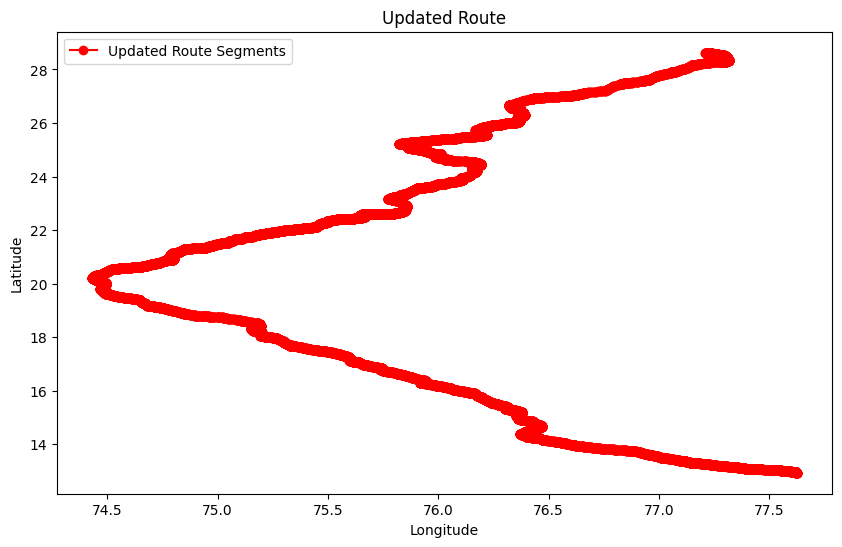

Updated ETA from current location ((28.621299743652344, 77.21029663085938)) to destination: 820.14 minutes


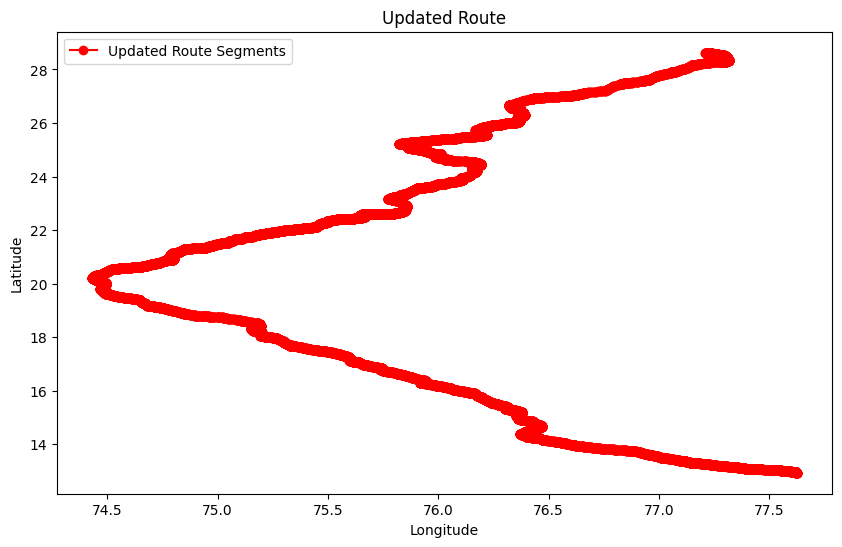

KeyboardInterrupt: 

In [16]:
import requests
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from geopy.distance import geodesic

osrm_url = "http://router.project-osrm.org/route/v1/driving/{},{};{},{}?overview=full&geometries=geojson"

end_location = (12.9371376, 77.6241392)  

df = pd.read_csv('cleaned_eta_prediction_data.csv')

def calculate_segment_length(start, end):
    return geodesic(start, end).meters

df['segment_length'] = df.apply(lambda row: calculate_segment_length((row['initial_lat'], row['initial_lon']), 
                                                                     (row['final_lat'], row['final_lon'])), axis=1)

X = df[['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length']]
y = df['time_taken']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_normalized, y)

average_segment_length = df['segment_length'].mean()

def get_current_location():
    access_key = '080ef27648be7d96af0413697f6b4b53'
    response = requests.get(f'http://api.ipstack.com/check?access_key={access_key}')
    
    if response.status_code == 200:
        data = response.json()
        return data['latitude'], data['longitude']
    else:
        raise Exception("Error fetching location data")

current_location = get_current_location()
print(f"Current Location: {current_location}")

def calculate_eta_from_current_location(current_location):
    route_url = osrm_url.format(current_location[1], current_location[0], end_location[1], end_location[0])
    response = requests.get(route_url)
    route_data = response.json()
    
    coordinates = route_data['routes'][0]['geometry']['coordinates']
    segment_points = [(coord[1], coord[0]) for coord in coordinates]

    total_eta = 0
    for i in range(len(segment_points) - 1):
        segment_start = segment_points[i]
        segment_end = segment_points[i + 1]

        segment_length = calculate_segment_length(segment_start, segment_end)

        segment_df = pd.DataFrame([[segment_start[0], segment_start[1], segment_end[0], segment_end[1], segment_length]],
                                  columns=['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length'])

        segment_normalized = scaler.transform(segment_df)

        predicted_eta = knn.predict(segment_normalized)[0]

        adjusted_eta = predicted_eta * (segment_length / average_segment_length)
        total_eta += adjusted_eta
    
    return total_eta, segment_points

while True:
    current_location = get_current_location()
    
    eta, segment_points = calculate_eta_from_current_location(current_location)
    
    print(f"Updated ETA from current location ({current_location}) to destination: {eta/60:.2f} minutes")
    
    plt.figure(figsize=(10, 6))
    lats, lons = zip(*segment_points)
    plt.plot(lons, lats, 'ro-', label='Updated Route Segments')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Updated Route')
    plt.legend()
    plt.show()
    
    if geodesic(current_location, end_location).meters < 10:
        print("Destination reached.")
        break
    
    time.sleep(10)
    
    current_location = (current_location[0] + 0.0001, current_location[1] + 0.0001)

